# 1. 芯片初始化操作

In [1]:
import time
import json
import numpy as np
import matplotlib.pyplot as plt

from pc import PS
from modules import ADC,DAC,CHIP
from cimCommand import CMD,CmdData,Packet
from cimCommand.singleCmdInfo import *

from util import plot_v_cond

In [2]:
chip=CHIP(PS(host="192.168.1.10", port = 7, delay=0.3, debug=0),init=True)
chip.set_device_cfg(deviceType=0)

Connected to 192.168.1.10:7
local ip: 192.168.1.15 local port: 51347


# 2. 读器件

## 2.1 常规读操作

In [30]:
chip.set_op_mode(read=True,from_row=True)                                   # 设置为读模式, 并且是从行读
chip.set_dac_read_V(0.1,tg=5)                                               # 设置读电压, 会根据device的自动配置对应的DAC通道
chip.adc.set_gain_resistor(big_resistance=10e3,small_resistance=200)        # 设置TIA增益使用的电阻大小
chip.set_tia_gain(1)                                                        # 设置TIA的增益
print(chip.get_setting_info())

操作模式: read	器件: ReRAM	读电压: 0.1v	从行\列给电压: 行	TIA增益: 1


In [31]:
voltage = chip.read(row_index=[100],col_index=[100],row_value=None,col_value=None,check_tia=True)
print(f"电压:{voltage}v")
cond = chip.voltage_to_cond(voltage=voltage)
print(f"电导:{cond}us")
resistance = chip.voltage_to_resistor(voltage=voltage)
print(f"电阻:{voltage}kΩ")

电压:[0.14358959]v
电导:[1191.79285773]us
电阻:[0.14358959]kΩ


## 2.2 自定义配置latch读操作

In [32]:
chip.set_op_mode(read=True,from_row=True)                                   # 设置为读模式, 并且是从行读
chip.set_dac_read_V(0.1,tg=5)                                               # 设置读电压, 会根据device的自动配置对应的DAC通道
chip.adc.set_gain_resistor(big_resistance=22e3,small_resistance=200)        # 设置TIA增益使用的电阻大小
chip.set_tia_gain(2)                                                        # 设置TIA的增益
print(chip.get_setting_info())

操作模式: read	器件: ReRAM	读电压: 0.1v	从行\列给电压: 行	TIA增益: 2


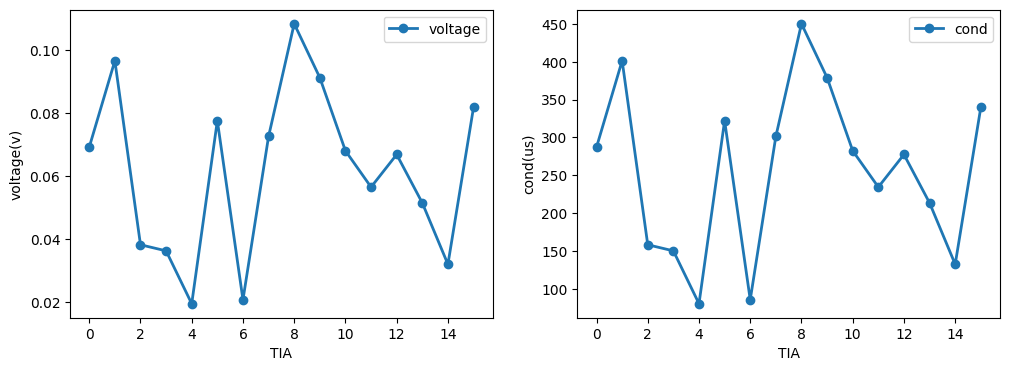

In [58]:
chip.set_op_mode(read=True,from_row=True)
chip.set_dac_read_V(0.2)
chip.set_tia_gain(1)

# 先需要reset所有的latch
chip.set_cim_reset()

# 选任意行配ltach
# chip.set_latch([0],row=True,value=None)
# 选任意行bank配32bit值
chip.set_bank([i for i in range(8)],row=True,value=0xFFFF_FFFF)

# 配置列bank
# chip.set_latch([[2,4,1,3]],row=False,value=None)
chip.set_bank([i for i in range(8)],row=False,value=0xFFFF_FFFF)

# 产生读脉冲, 并读出tia值
chip.generate_read_pulse()
voltage = chip.get_tia_out([k for k in range(16)])

plot_v_cond(v= voltage,cond= chip.voltage_to_cond(voltage))

# 3. 写器件

## 3.1 常规写操作

In [60]:
chip.set_op_mode(read=False,from_row=True)                                  # 设置为写模式, 并且是从行写
chip.set_dac_write_V(0.1)                                                   # 设置为写模式, 并且是从行写
chip.set_pulse_width(0.1)                                                   # 设置写脉冲宽度
print(chip.get_setting_info())

操作模式: write	器件: ECRAM	写电压: 0.1v	从行\列给电压: 行	脉宽: 10000000


In [ ]:
chip.write_one(row_index=0,col_index=0)

## 3.2 自定义配置行列写操作

In [ ]:
chip.set_op_mode(read=False,from_row=True)                                  # 设置为写模式, 并且是从行写
chip.set_dac_write_V(0.1)                                                   # 设置为写模式, 并且是从行写
chip.set_pulse_width(0.1)                                                   # 设置写脉冲宽度
print(chip.get_setting_info())

In [ ]:
# 先需要reset所有的latch
chip.set_cim_reset()

# 配置行bank
chip.set_latch([2,4,253,255],row=True,value=None)
chip.set_bank([i for i in range(8)],row=True,value=0xFFFF_FFFF)

# 配置列bank
chip.set_latch([[2,4,1,3]],row=False,value=None)
chip.set_bank([i for i in range(8)],row=False,value=0xFFFF_FFFF)

# 产生写配置
chip.generate_write_pulse()

# 3. 测试

## 3.1 测试选通对不对

In [33]:
chip.set_op_mode(read=True,from_row=True)                                   # 设置为读模式, 并且是从行读
chip.set_dac_read_V(0.1,tg=5)                                               # 设置读电压, 会根据device的自动配置对应的DAC通道
chip.adc.set_gain_resistor(big_resistance=10e3,small_resistance=200)        # 设置TIA增益使用的电阻大小
chip.set_tia_gain(1)                                                        # 设置TIA的增益
print(chip.get_setting_info())

操作模式: read	器件: ReRAM	读电压: 0.1v	从行\列给电压: 行	TIA增益: 1


In [34]:
# 0或1 ：串行读写32个寄存器的使能
chip.send_cmd(cmd = [CMD(CIM_EN,command_data=CmdData(1))],mode=1)

In [49]:
def is_correct_value(voltage,threshold,tia_num):
    for key,value in enumerate(voltage):
        if value>=threshold:
            if key in tia_num:
                pass
            else:
                print(f"这路TIA应该有值:tia={key},value={value},threshold={threshold}")
                return False
        else:
            if key not in tia_num:
                pass
            else:
                print(f"这路TIA不应该有值:tia={key},value={value},threshold={threshold}")
                return False
    return True

第0, 1位设置为1 [ 2.93740654e-03  5.11185034e-03  4.20773949e-02  4.53962828e-03
  3.56303598e-02  1.44962920e-03  1.72429579e-02  6.40888699e-03
  0.00000000e+00  4.20010987e-02  3.81481368e-02 -6.48518326e-04
  7.94320505e-01  1.71666616e-03  3.20444349e-03 -4.08185064e-03]


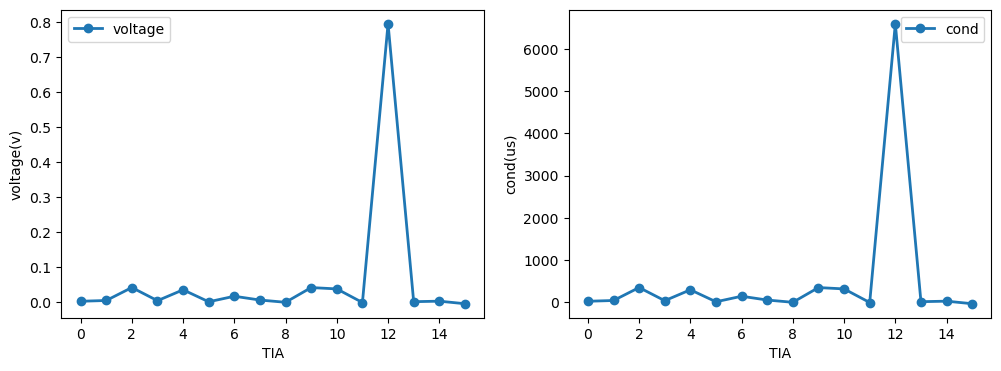

第0次挤出一位
True
第1次挤出一位
True
第2次挤出一位
True
第3次挤出一位
True
第4次挤出一位
True
第5次挤出一位
True
第6次挤出一位
True
第7次挤出一位
True
第8次挤出一位
True
第9次挤出一位
True
第10次挤出一位
True
第11次挤出一位
True
第12次挤出一位
True
第13次挤出一位
True
第14次挤出一位
True
第15次挤出一位
True
第16次挤出一位
True
第17次挤出一位
True
第18次挤出一位
True
第19次挤出一位
True
第20次挤出一位
True
第21次挤出一位
True
第22次挤出一位
True
第23次挤出一位
True
第24次挤出一位
True
第25次挤出一位
True
第26次挤出一位
True
第27次挤出一位
True
第28次挤出一位
True
第29次挤出一位
True
第30次挤出一位
True
第31次挤出一位
True


In [60]:
col_bank = 2

chip.send_cmd(cmd = [CMD(SER_PARA_SEL,command_data=CmdData(1))],mode=1)
chip.set_cim_reset()
chip.set_bank([0],row=True,value=0xFFFF_FFFF)
chip.set_bank([col_bank],row=False,value=0x0000_0003)
col_index = chip.bank_to_num([col_bank])

chip.generate_read_pulse()
voltage = chip.get_tia_out([k for k in range(16)])

print(f"第{0}, {1}位设置为1",voltage)
plot_v_cond(voltage,chip.voltage_to_cond(voltage))

for j in range(32):
    chip.send_cmd(cmd = [CMD(SER_PARA_SEL,command_data=CmdData(0))],mode=1)
    chip.send_cmd(cmd = [CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_reg_clk))],mode=1)          # cfg_reg_clk
    chip.send_cmd(cmd = [CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_latch_clk))],mode=1)        # cfg_latch_clk

    chip.generate_read_pulse()
    voltage = chip.get_tia_out([k for k in range(16)])
    print(f"第{j}次挤出一位")
    # plot_v_cond(voltage,chip.voltage_to_cond(voltage))
    if j == 31:
        print(is_correct_value(voltage,0.1,tia_num=[]))
    else:
        col1,col2= col_index[min(31,j+1)],col_index[min(31,j+2)]
        tia = [chip.adc.TIA_index_map(col1),chip.adc.TIA_index_map(col2)]
        print(is_correct_value(voltage,0.1,tia_num=tia))

### 测试delay延迟

In [37]:
op_bank_cfg_done_delay_cyc = 1000
op_cim_data_cfg_done_delay_cyc = 1000
reg_clk_done_delay_cyc = 1000
latch_clk_done_delay_cyc = 1000
# op_adc_avrg_done_delay_cyc = 1000
# op_dac_cfg_done_delay_cyc = 1000
# op_row_pulse_done_delay_cyc = 1000
# op_col_pulse_done_delay_cyc = 1000
# op_cim_rstn_done_delay_cyc = 1000

pkts=Packet()
pkts.append_cmdlist([
    # CMD(OP_BANK_CFG_DONE_DELAY_CYC,command_data=CmdData(1000)),
    CMD(OP_CIM_DATA_CFG_DONE_DELAY_CYC,command_data=CmdData(10000)),
    CMD(REG_CLK_DONE_DELAY_CYC,command_data=CmdData(10000)),
    CMD(LATCH_CLK_DONE_DELAY_CYC,command_data=CmdData(10000)),
    # CMD(OP_ADC_AVRG_DONE_DELAY_CYC,command_data=CmdData(1000)),
    # CMD(OP_DAC_AVRG_DONE_DELAY_CYC,command_data=CmdData(1000)),
    # CMD(OP_ROW_PULSE_DONE_DELAY_CYC,command_data=CmdData(1000)),
    # CMD(OP_COL_PULSE_DONE_DELAY_CYC,command_data=CmdData(1000)),
    # CMD(OP_CIM_RSTN_DONE_DELAY_CYC,command_data=CmdData(1000)),
],mode=1)
chip.ps.send_packets(pkts)